# Exploratory data analysis

In [1]:
# Loading the data
import pickle
import numpy as np

local_filename = '../dataset/data.pkl'
dataset = []

with open(local_filename, "rb") as file:
    # Deserializing which is a transforming serialized data back into its original format
    dataset = pickle.load(file)
            
trainDataset = dataset["trainDataset"]
testDataset = dataset["testDataset"]

print("Train Size: {} Test Size: {}".format(len(trainDataset), len(testDataset)))

Train Size: 60000 Test Size: 27561


In [2]:
import numpy as np

X_train = np.array([td["image"] for td in trainDataset])
y_train = np.array([td["label"] for td in trainDataset]) 
X_test = np.array([td["image"] for td in testDataset])
y_test = np.array([td["label"] for td in testDataset])

## Visualizing Dataset

In [3]:
import matplotlib.pyplot as plt

In [4]:
def show_images(x, y, title_str='Label'):
    for c in range(1, 10):
        plt.subplot(3, 3, c)
        i = np.random.randint(len(x)) # Generate random integer number
        im = x[i] # get i-th image
        plt.axis("off")
        label = y[i] # get i-th label
        plt.title("{} = {}".format(title_str, label))
        plt.imshow(im, cmap='Greys')

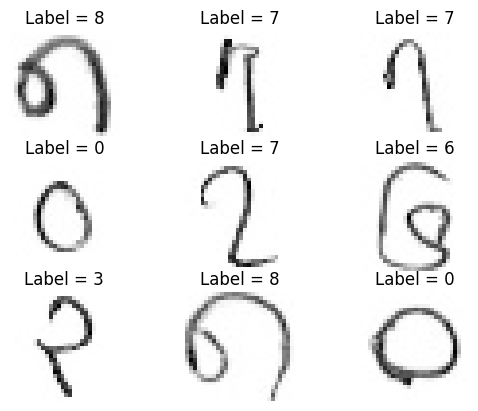

In [5]:
# Visualzing training set
show_images(X_train, y_train, title_str='Label')

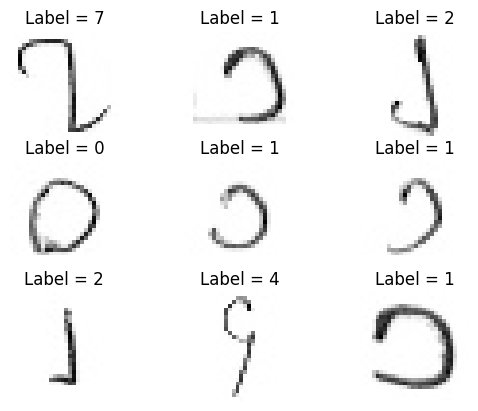

In [6]:
# Visualzing test set
show_images(X_test, y_test, title_str='Label')

## Data Preprocessing

In [7]:
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (27561, 28, 28)
y_test shape: (27561,)


In [8]:
# Labels
label = np.unique(y_train)
num_classes = len(label)
print("Number of classes:", num_classes)
print("Unique Labels:", label)

Number of classes: 10
Unique Labels: [0 1 2 3 4 5 6 7 8 9]


In [9]:
# Reshape images
X_train = X_train.astype(np.float32).reshape(len(X_train), 28, 28, 1)
y_train = y_train.reshape(len(y_train), 1)
X_test = X_test.astype(np.float32).reshape(len(X_test), 28, 28, 1)
y_test = y_test.reshape(len(y_test), 1)

In [10]:
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")

X_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 1)
X_test shape: (27561, 28, 28, 1)
y_test shape: (27561, 1)


In [11]:
# Split into training, validation, and test sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

**Note:** I created a custom preprocessing layer which can encapsulate our preprocessing logic and become part of the model. When we save the model, these custom preprocessing layers will be included.

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

# Custom preprocessing layer with Normalization
class CustomPreprocessNormalizationLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(CustomPreprocessNormalizationLayer, self).__init__()

    def call(self, inputs):
        # Normalize pixel values to [0, 1]
        normalized_images = inputs / 255.0

        return normalized_images

In [20]:
# Custom preprocessing layer with Standardization
class CustomPreprocessStandardizationLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(CustomPreprocessStandardizationLayer, self).__init__()

    def call(self, inputs):
        # Standardize pixel values into mean=0 and std=1
        standardized_images = (inputs - tf.math.reduce_mean(inputs)) / tf.math.reduce_std(inputs)
        
        return standardized_images

# Building the model

In [21]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential

In [22]:
def create_model():
    # Create a Sequential model
    model = Sequential()

    # Add the CustomPreprocessNormalizationLayer as the first layer
    model.add(CustomPreprocessNormalizationLayer())

    ### Add Convolutional and MaxPooling layers
    
    # CONV => RELU => MAX-POOLING
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    
    # CONV => RELU => MAX-POOLING => CONV
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))

    # Flatten the output for Dense layers
    model.add(Flatten())

    # Add Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    return model

In [23]:
model = create_model()

In [24]:
# Configures the model for training
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
# Train the model
epoch = 10
history = model.fit(X_train, y_train,
                    epochs=epoch,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/10
   4/1500 [..............................] - ETA: 26s - loss: 0.0854 - accuracy: 0.9922

2023-08-11 23:12:29.393635: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


1500/1500 [==============================] - 27s 18ms/step - loss: 0.0322 - accuracy: 0.9915 - val_loss: 0.0346 - val_accuracy: 0.9914
Epoch 2/10
1500/1500 [==============================] - 26s 17ms/step - loss: 0.0201 - accuracy: 0.9941 - val_loss: 0.0257 - val_accuracy: 0.9933
Epoch 3/10
1500/1500 [==============================] - 26s 17ms/step - loss: 0.0122 - accuracy: 0.9965 - val_loss: 0.0163 - val_accuracy: 0.9958
Epoch 4/10
1500/1500 [==============================] - 26s 17ms/step - loss: 0.0094 - accuracy: 0.9972 - val_loss: 0.0207 - val_accuracy: 0.9943
Epoch 5/10
1500/1500 [==============================] - 26s 17ms/step - loss: 0.0082 - accuracy: 0.9976 - val_loss: 0.0166 - val_accuracy: 0.9952
Epoch 6/10
1500/1500 [==============================] - 26s 17ms/step - loss: 0.0052 - accuracy: 0.9985 - val_loss: 0.0223 - val_accuracy: 0.9950
Epoch 7/10
1500/1500 [==============================] - 26s 17ms/step - loss: 0.0060 - accuracy: 0.9982 - val_loss: 0.0201 - val_accura

In [27]:
# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_preprocess_normaliza  (32, 28, 28, 1)          0         
 tion_layer_1 (CustomPreproc                                     
 essNormalizationLayer)                                          
                                                                 
 conv2d_3 (Conv2D)           (32, 26, 26, 32)          320       
                                                                 
 max_pooling2d_2 (MaxPooling  (32, 13, 13, 32)         0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (32, 11, 11, 64)          18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (32, 5, 5, 64)           0         
 2D)                                                  

In [28]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [29]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

862/862 [==============================] - 5s 6ms/step - loss: 0.0234 - accuracy: 0.9964
Test accuracy: 99.64%


In [30]:
predictions = model.predict(X_test) # Make predictions towards the test set

862/862 [==============================] - 5s 5ms/step


In [31]:
np.argmax(predictions[1]), y_test[1] # If two are the same, got it right

(5, array([5], dtype=uint8))

In [32]:
y_test_pred = np.argmax(predictions, axis=1)

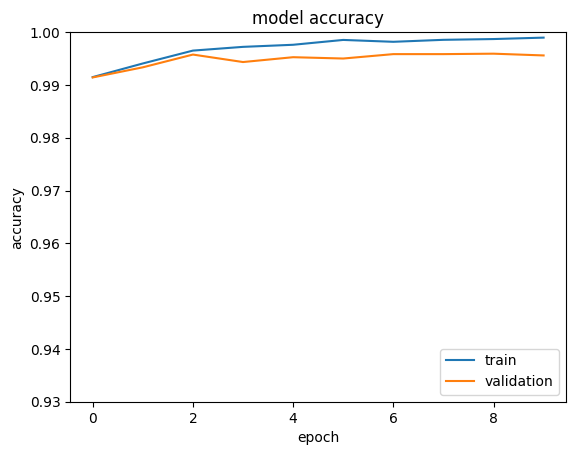

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("model accuracy")
plt.ylim([0.93, 1.0])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['train','validation'],loc='lower right')
plt.show()

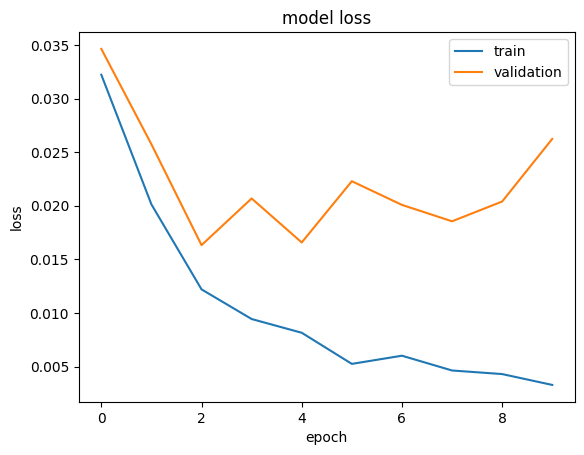

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train','validation'],loc='upper right')
plt.show()

# Model Evaluation

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [36]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_test_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_test_pred, average = 'macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_test_pred, average = 'macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_test_pred, average = 'macro')
print('F1 score: %f' % f1)

Accuracy: 0.996372
Precision: 0.992708
Recall: 0.995681
F1 score: 0.994182


# Testing a real-world image

In [155]:
image_path = "../images/Burmese_number_5.jpg"
img_input = tf.io.read_file(image_path)
img_input = tf.image.decode_image(img_input)
img_input = tf.image.rgb_to_grayscale(img_input)
img_input = 255 - img_input
img_input = tf.image.resize(img_input, size=(28, 28), method='bilinear')

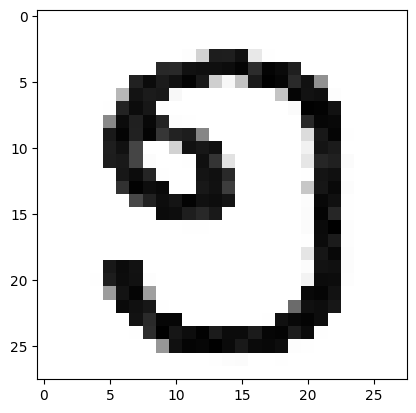

In [156]:
plt.imshow(img_input, cmap='Greys')

In [1]:
img_input = tf.expand_dims(img_input, axis=0)

NameError: name 'tf' is not defined

In [154]:
y_input_pred = model.predict(img_input)
print(np.argmax(y_input_pred))

1/1 [==============================] - 0s 32ms/step
3
